In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

# Clasificación multiclase

## Creamos datos

In [3]:
#hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

#array to tensor
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

#split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

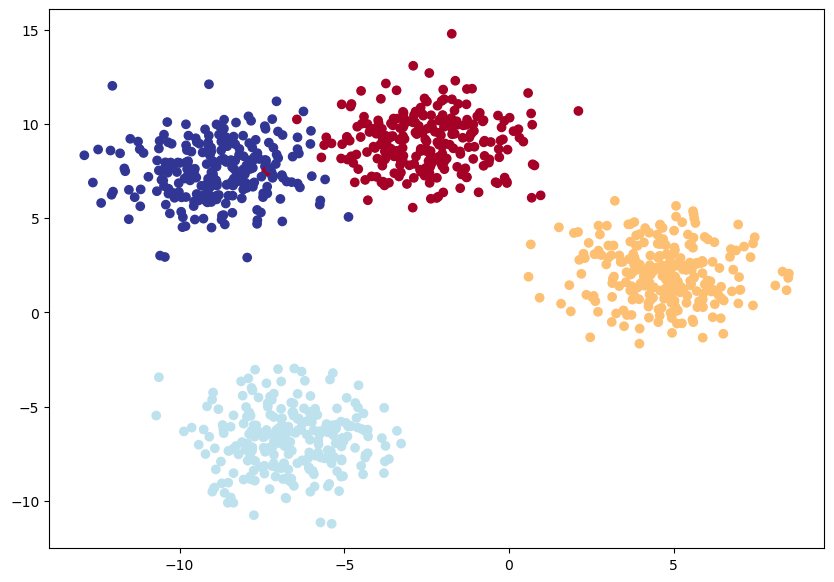

In [4]:
#plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [5]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

## Modelo de multi-class classification

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multi-class classification model.
        Input:
            - input_features: int type object. Number of input features to the model
            - output_features: int type object. Number of output features from the model (output classes)
            - hidden_units: int type object. Number of hidden units between layers. 8 by default.
        """
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [7]:
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

## Loss function, optimizador y train/test loop para multi-class classification

Para obtener las predicciones:

Logits (raw output) -> Pred probs (torch.softmax()) -> Pred labels (argmax) 

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [9]:
torch.manual_seed(42)
epochs = 100

for epoch in range(epochs):
    #Train
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.40, Acc: 27.38% | Test loss: 1.18, Test acc: 54.00%
Epoch: 10 | Loss: 0.65, Acc: 77.00% | Test loss: 0.57, Test acc: 79.00%
Epoch: 20 | Loss: 0.20, Acc: 99.12% | Test loss: 0.17, Test acc: 99.50%
Epoch: 30 | Loss: 0.10, Acc: 99.00% | Test loss: 0.09, Test acc: 99.50%
Epoch: 40 | Loss: 0.07, Acc: 99.12% | Test loss: 0.06, Test acc: 99.50%
Epoch: 50 | Loss: 0.06, Acc: 99.12% | Test loss: 0.05, Test acc: 99.50%
Epoch: 60 | Loss: 0.05, Acc: 99.12% | Test loss: 0.04, Test acc: 99.50%
Epoch: 70 | Loss: 0.04, Acc: 99.12% | Test loss: 0.03, Test acc: 99.50%
Epoch: 80 | Loss: 0.04, Acc: 99.12% | Test loss: 0.03, Test acc: 99.50%
Epoch: 90 | Loss: 0.04, Acc: 99.12% | Test loss: 0.03, Test acc: 99.50%


## Evaluación del modelo

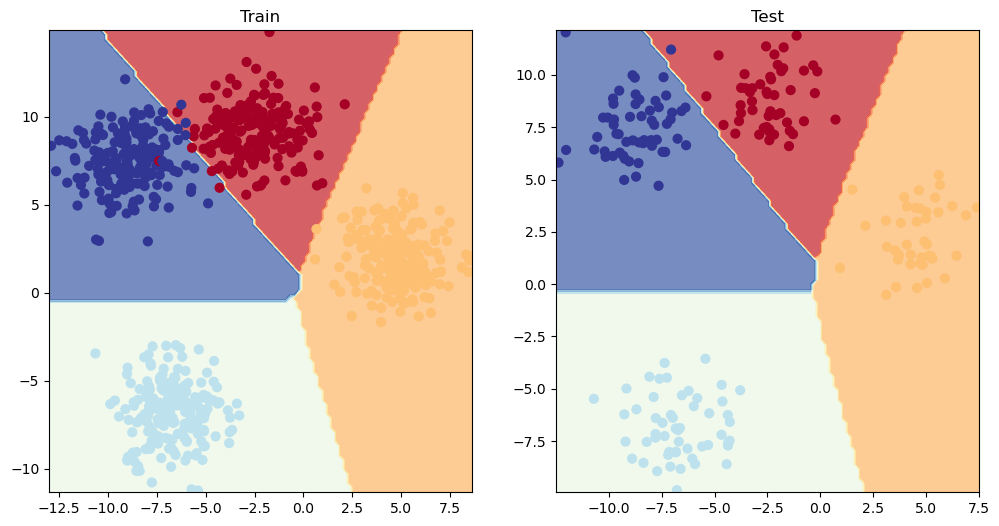

In [17]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

Vemos que las regiones están limitadas casi linealmente, esto es posible por que los datos que tenemos son linealmente separable. Para este problema podríamos implementar solo funciones lineales en la solución pero no sería aplicable en otras situaciones

## Métricas de evaluación de modelos de clasificación

-   Exactitud: De 100 muestras, cuantas acierta el modelo? Sirve cuando las muestras de clases 
-   Presición: Una alta presición lleva a menos falsos positivos. Sirve para muestras no balanceadas
-   Recall: Un recall alto lleva a menos falsos positivos. Sirve para muestras no balanceadas

    *Usualmente, si se aumenta la presición disminuye el recall y viceversa*

-   F1-score: Combina presición y recall
-   Matriz de confusión: Te dice cuando el modelo se confunde. Es dificil de usar cuando existen muchas cantidades de clases
-   Classification report: Combina todos los métodos